# 🚗 PAG, Por Techsos Team 🚌

En este cuaderno, trabajaremos en un proyecto de clasificación de imágenes utilizando el modelo **VGG16** con técnicas de **Transfer Learning** y **Fine-Tuning**. El objetivo es clasificar imágenes de vehículos en tres categorías: **coches (car)**, **autobuses (bus)** y **camiones (truck)**.

---

## 📦Montar Google Drive y Descomprimir Datos

Primero, montamos Google Drive para acceder a los archivos ZIP que contienen las imágenes de vehículos. Luego, descomprimimos estos archivos en carpetas específicas.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import zipfile
import os

# Ruta al archivo zip en Google Drive
ruta_car_zip = '/content/drive/MyDrive/car.zip'
ruta_bus_zip = '/content/drive/MyDrive/bus.zip'
ruta_truck_zip = '/content/drive/MyDrive/truck.zip'

# Descomprimir archivos
with zipfile.ZipFile(ruta_car_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/car')

with zipfile.ZipFile(ruta_bus_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/bus')

with zipfile.ZipFile(ruta_truck_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/truck')

Mounted at /content/drive/


🖼️Visualización de la Data
Antes de entrenar el modelo, es importante visualizar algunas imágenes para entender la estructura de los datos. Aquí mostramos 10 imágenes de cada categoría, que además tienen diferentes tamaños.

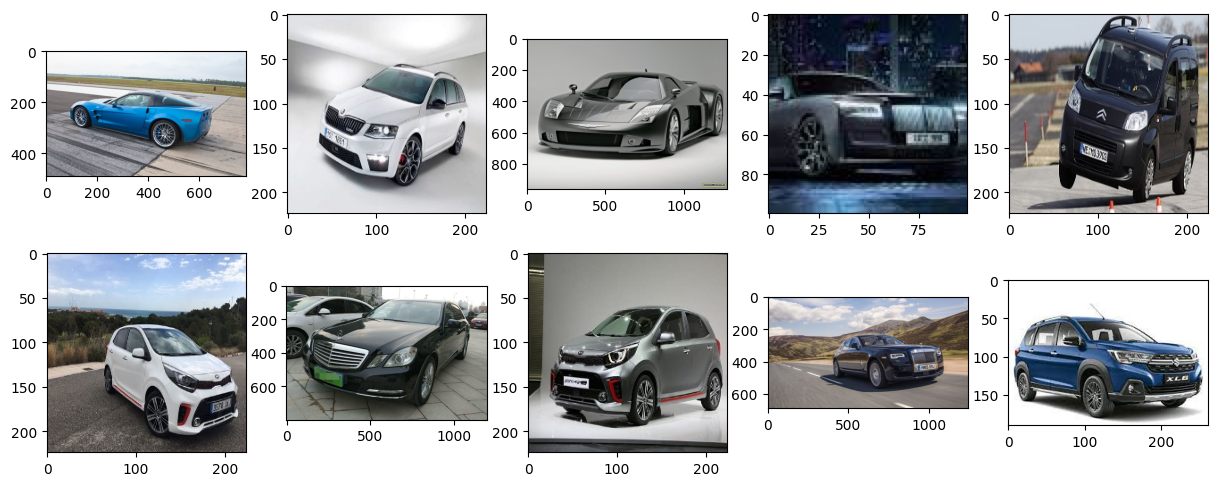

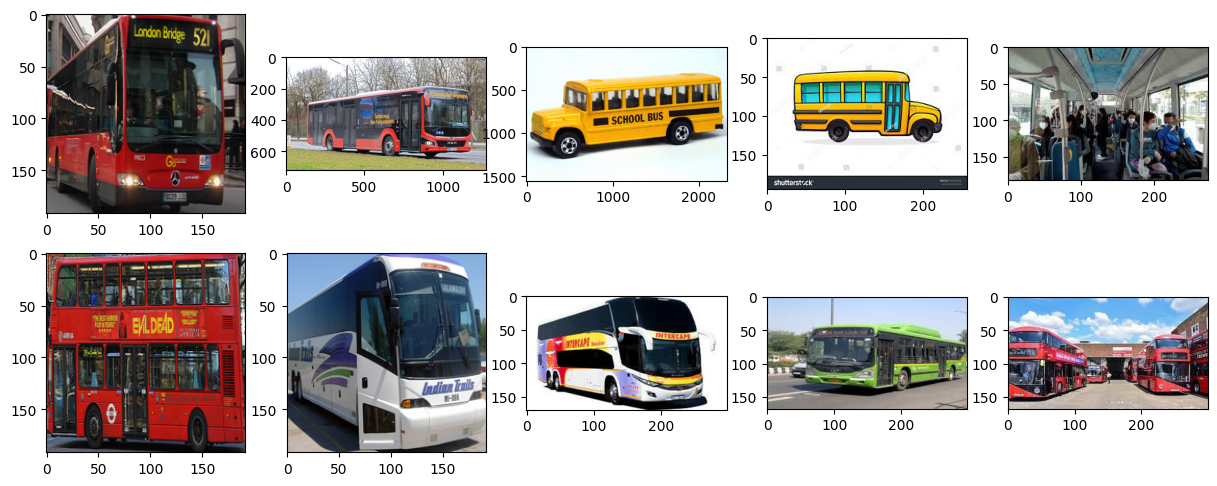

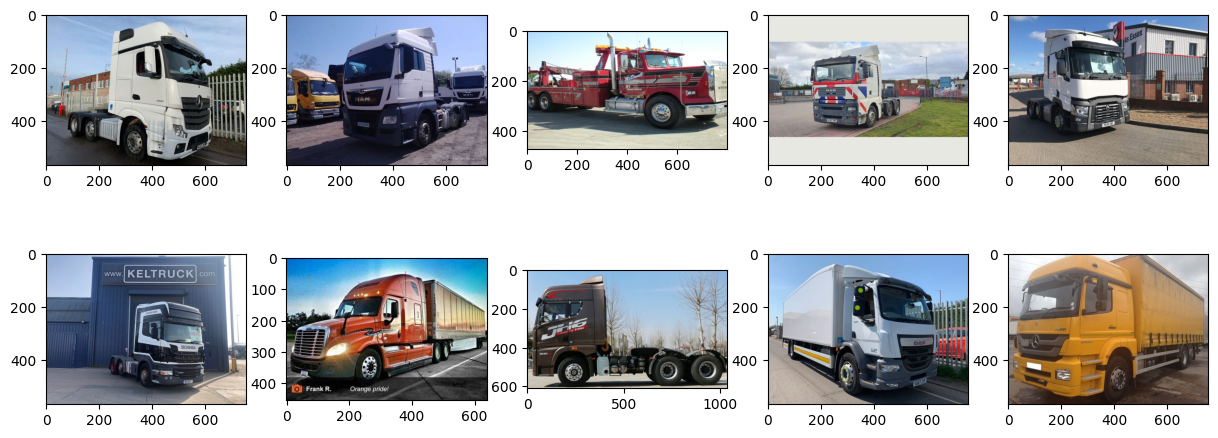

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(15,15))
folder= '/content/car/car'
images = os.listdir(folder)

for i, image_name in enumerate(images[:10]):
 plt.subplot(5,5,i+1)
 img = mpimg.imread(folder + '/' + image_name)
 plt.imshow(img)

plt.figure(figsize=(15,15))
folder= '/content/bus/bus'
images = os.listdir(folder)

for i, image_name in enumerate(images[:10]):
 plt.subplot(5,5,i+1)
 img = mpimg.imread(folder + '/' + image_name)
 plt.imshow(img)

plt.figure(figsize=(15,15))
folder= '/content/truck/truck'
images = os.listdir(folder)

for i, image_name in enumerate(images[:10]):
 plt.subplot(5,5,i+1)
 img = mpimg.imread(folder + '/' + image_name)
 plt.imshow(img)

👀 Preparación del Dataset
Creamos un nuevo directorio llamado dataset y copiamos las imágenes en carpetas separadas para cada categoría. Esto nos ayudará a organizar los datos para el entrenamiento.

In [3]:
!mkdir /content/dataset
!mkdir /content/dataset/truck
!mkdir /content/dataset/bus
!mkdir /content/dataset/car

import shutil

final_folder = '/content/dataset/car'
folder = '/content/car/car'
images = os.listdir(folder)
for i, image_name in enumerate(images):
    if i < 1961:
        shutil.copy(folder + '/' + image_name, final_folder + '/' + image_name)

final_folder = '/content/dataset/bus'
folder = '/content/bus/bus'
images = os.listdir(folder)
for i, image_name in enumerate(images):
    if i < 1961:
        shutil.copy(folder + '/' + image_name, final_folder + '/' + image_name)

final_folder = '/content/dataset/truck'
folder = '/content/truck/truck'
images = os.listdir(folder)
for i, image_name in enumerate(images):
    if i < 1961:
        shutil.copy(folder + '/' + image_name, final_folder + '/' + image_name)

🗂️ Data Augmentation y Generadores de Datos
Utilizamos ImageDataGenerator para aplicar técnicas de aumento de datos (data augmentation) y dividir el dataset en conjuntos de entrenamiento y validación.

Found 4707 images belonging to 3 classes.
Found 1176 images belonging to 3 classes.


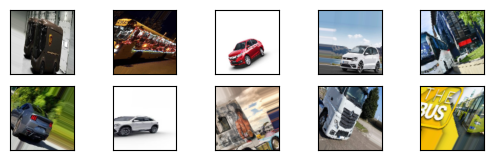

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset = '/content/dataset'
datagene = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=[0.5, 1.5],
    validation_split=0.2
)

datagen_t = datagene.flow_from_directory(dataset, target_size=(128, 128), batch_size=32, shuffle=True, subset='training')
datagen_v = datagene.flow_from_directory(dataset, target_size=(128, 128), batch_size=32, shuffle=True, subset='validation')

for image, lol in datagen_t:
  for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i])
  break

🌀 Construcción del Modelo VGG16
Utilizamos el modelo VGG16 preentrenado y añadimos capas personalizadas para adaptarlo a nuestro problema de clasificación.

In [5]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Cargar VGG16 sin las capas fully connected
model_fe = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')
model_fe.trainable = False  # Congelar las capas de VGG16

# Añadir capas personalizadas
model = keras.Sequential([
    model_fe,
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 clases: bus, car, truck
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

🏋️ Entrenamiento del Modelo
Entrenamos el modelo utilizando el generador de datos y monitorizamos el rendimiento con ReduceLROnPlateau.

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(datagen_t,
                    epochs=60,
                    batch_size=32,
                    validation_data=datagen_v,
                    callbacks=[lr_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
  1/148 ━━━━━━━━━━━━━━━━━━━━ 21:20 9s/step - accuracy: 0.3125 - loss: 1.3057

KeyboardInterrupt: 

🎯 Fine-Tuning del Modelo
Aplicamos Fine-Tuning para ajustar las últimas capas de VGG16 y mejorar el rendimiento del modelo.

In [ ]:
for layer in model_fe.layers[-5:]:
    layer.trainable = True  # Descongelar las últimas 5 capas

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(datagen_t,
                             epochs=30,
                             batch_size=32,
                             validation_data=datagen_v,
                             callbacks=[lr_reduction])

💾 Guardar el Modelo
Finalmente, guardamos el modelo entrenado para su uso futuro.

In [ ]:
model.save('mi_modelov2.h5')

🔍 Pruebas y Predicciones
Podemos probar el modelo con imágenes nuevas desde una URL.

In [10]:
import requests
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

def lehagopredict(url):
    response = requests.get(url)
    img = image.load_img(BytesIO(response.content), target_size=(128, 128))
    img = np.array(img).astype(float) / 255.0
    img = cv2.resize(img, (128, 128))
    prediccion = model.predict(img.reshape(-1, 128, 128, 3))
    return np.argmax(prediccion[0], axis=-1)

url = 'https://i.pinimg.com/236x/57/ac/ae/57acaef092da6293d15974d439ac289b.jpg'
prediccion = lehagopredict(url)
print(f'Predicción: {prediccion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Predicción: 2


📊 Visualización de Resultados
Incluimos gráficos de precisión, pérdida y una matriz de confusión para evaluar el rendimiento del modelo.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

y_true = [0, 1, 2, 1, 0]
y_pred = [0, 1, 2, 0, 1]
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bus', 'Car', 'Truck'], yticklabels=['Bus', 'Car', 'Truck'])
plt.title('Confusion Matrix')
plt.show()

##Probar el modelo ya entrenado:

#Cargar el modelo

In [8]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('mi_modelov4.h5')

Testear el modelo:

In [11]:
from tensorflow.keras.models import load_model
model = load_model('mi_modelov4.h5')

def lehagopredict(url):
    # Descargar la imagen desde la URL
    response = requests.get(url)
    img = image.load_img(BytesIO(response.content), target_size=(128, 128))

    img = np.array(img).astype(float) / 255.0
    img = cv2.resize(img, (128, 128))

    prediccion = model.predict(img.reshape(-1, 128, 128, 3))
    return np.argmax(prediccion[0], axis=-1)

# URL de la imagen a predecir
url = 'https://thumbs.dreamstime.com/b/omnibus-moderno-14248029.jpg'

prediccion = lehagopredict(url)
print(f'Predicción: {prediccion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Predicción: 0
